# Gaussian Process Regression Model 

Squared exponential kernel 

$
k(x_1, x_2) = \sigma^2 \exp{(-||x_2 - x_1||^2_2 / (2 \ell))}, 
$
where $\ell > 0$ is the lengthscale and $\sigma^2 > 0$ is variance.

Multivariate Normal distribution adoptation

$
\mathcal{N}(K_1 K^{-1} y, K_2 - K_1 K^{-1} K_1^\text{T}) + \sigma^2 I 
$



In [8]:
import numpy as np 
import matplotlib.pyplot as plt 

In [13]:
class SquareExponentialKernel:

    def __init__(self, sigma=0.1, ell=0.1):
        self.sigma = sigma 
        self.ell   = ell 
    
    def __call__(self, x1, x2):
        return self.sigma**2 * np.exp(-np.linalg.norm(x2 - x1)**2 / (2 * self.ell))
    
class GPR:

    def __init__(self, inp_x, inp_y, noise, covariance_function=SquareExponentialKernel()):
        self.inp_x = inp_x 
        self.inp_y = inp_y 
        self.covariance_function = covariance_function
        self.noise = noise
        self.buff  = None 
    
    def predict(self, ):





In [31]:
k = SquareExponentialKernell(0.001, 0.001)


In [32]:
rng = np.arange(0,1,0.01)
M = np.array([[k(a,b) for a in rng] for b in rng])


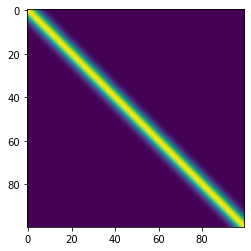

In [33]:
plt.imshow(M)
plt.show()

In [35]:
np.cov([[0, 1, 2], [0, 1, 2]])


array([[1., 1.],
       [1., 1.]])